In [1]:
#Import data from Google Drive 
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
#Load Data
import shutil
data_dir_train = 'gdrive/MyDrive/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train'
data_dir_test = 'gdrive/MyDrive/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test'

destination = 'gdrive/MyDrive/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_data'

In [3]:
#Import Libraries 
import tensorflow as tf 
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd 
from PIL import Image
import glob
import numpy as np

In [4]:
#define parameters 
batch_size = 32
img_width = 224
img_height = 224 
epochs = 20

seed = 10
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
#Split data 

train_image_data = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1.0/255.0,
    horizontal_flip = True, 
    zoom_range=0.2, 
    shear_range = 0.2,
)

train_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="training")

val_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [6]:
train_steps = train_ds.samples//batch_size
val_steps = val_ds.samples//batch_size

In [14]:
pip install Keras-Applications==1.0.8

     |████████████████████████████████| 50 kB 7.3 MB/s 


In [7]:
from keras.applications import resnet

In [8]:
#Create Model
model = tf.keras.Sequential([
            tf.keras.applications.resnet_v2.ResNet152V2(input_shape=[224,224, 3], include_top=False, weights='imagenet'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(12, activation='softmax')
])

model.summary()

234561536/234545216 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_______________________________________________________

In [9]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#Save model checkpoint
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [10]:
#Train Model
history = model.fit_generator(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = epochs)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
118/118 [==============================] - 3460s 29s/step - loss: 2.3259 - accuracy: 0.2403 - val_loss: 1.9849 - val_accuracy: 0.3556
Epoch 2/20
118/118 [==============================] - 218s 2s/step - loss: 1.4301 - accuracy: 0.5354 - val_loss: 1.0555 - val_accuracy: 0.6821
Epoch 3/20
118/118 [==============================] - 218s 2s/step - loss: 0.9249 - accuracy: 0.6985 - val_loss: 0.5592 - val_accuracy: 0.8394
Epoch 4/20
118/118 [==============================] - 218s 2s/step - loss: 0.7088 - accuracy: 0.7783 - val_loss: 0.4281 - val_accuracy: 0.8793
Epoch 5/20
118/118 [==============================] - 218s 2s/step - loss: 0.5478 - accuracy: 0.8250 - val_loss: 0.4090 - val_accuracy: 0.8707
Epoch 6/20
118/118 [==============================] - 219s 2s/step - loss: 0.4546 - accuracy: 0.8478 - val_loss: 0.3346 - val_accuracy: 0.9052
Epoch 7/20
118/118 [==============================] - 219s 2s/step - loss: 0.3838 - accuracy: 0.8780 - val_loss: 0.3313 - val_accuracy: 0.90

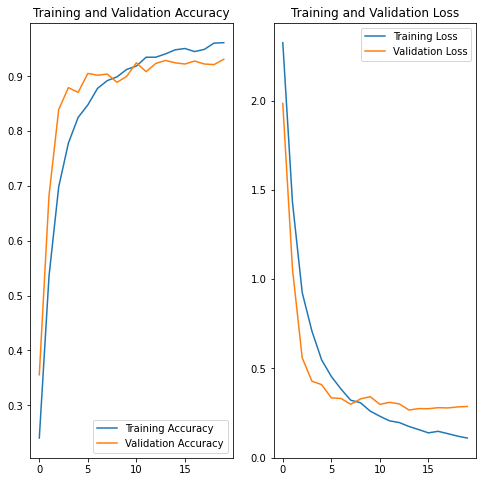

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
#Apply model to test set 
#Initialise test generator
test_image_data = ImageDataGenerator(rescale=1./255)
test_ds = test_image_data.flow_from_directory(destination,
                                              target_size=(img_height,img_width),
                                              batch_size = 1,
                                              class_mode ='categorical',
                                              shuffle = False)

Found 794 images belonging to 1 classes.


In [14]:
model.evaluate_generator(generator=val_ds, steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.30122876167297363, 0.9267241358757019]

In [15]:
test_ds.reset() #maintain test order
test_predictions = model.predict_generator(test_ds, test_ds.samples, verbose=1 )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


794/794 [==============================] - 468s 585ms/step


In [16]:
predicted_plant_type = np.argmax(test_predictions, axis=1)

In [17]:
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_plant_type]

In [18]:
test_pred = []
filenames=test_ds.filenames
for name in range(len(filenames)):
    test_pred.append(filenames[name].split('/')[1])

results=pd.DataFrame({"file":test_pred,
                      "species":predictions})
results.to_csv("submission.csv",index=False)